# Das automatisierte Krankenhaus

Wir wollen einen Klassifikator bauen, der anhand von gemessenen Daten entscheidet, ob ein Patient im Krankenhaus oder ambulant behandelt wird. 

Dabei schauen wir uns folgende Sachen im Detail an:
* Verschiedene Machine Learning Algorithmen wie SVM, DecisionTree, RandomForest und XGBoost
* Optimieren Machine Learning Algorithmen durch Parameter- und Hyperparameter-Tuning

Die Daten sind Teil der Veröffentlichung "Sadikin, Mujiono (2020), “EHR Dataset for Patient Treatment Classification”, Mendeley Data" und verfügbar unter: [Link] (https://data.mendeley.com/datasets/7kv3rctx7m/1/files/e1aea094-1201-4b28-a9ce-53dd8117f02c)

##1 Dateien einlesen

In [ ]:
import pandas as pd   # Importieren Standard-Library für das Bearbeiten und Laden von Daten ("Data Engineering").
import matplotlib.pyplot as plt # Standard-Library für das Plotten von Graphen.
import seaborn as sns   # verschönert Matplotlib-Graphiken
import numpy as np # Standard-Library für Rechnen

In [ ]:
# Hochladen Datensatz über eine Eingabemaske von lokalem Rechner etc.
from google.colab import files
files.upload()
Patients_df = pd.read_csv('data-ori.csv', sep=',')

Saving data-ori.csv to data-ori.csv


In [ ]:
Patients_df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out
...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,in
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,in
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,out
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,in


Hier eine kurze Erklärung der Daten, entnommen aus: [Link](https://www.kaggle.com/manishkc06/patient-treatment-classification)

* HAEMATOCRIT /Continuous /35.1 / Patient laboratory test result of haematocrit
* HAEMOGLOBINS/Continuous/11.8 / Patient laboratory test result of haemoglobins
* ERYTHROCYTE/Continuous/4.65 / Patient laboratory test result of erythrocyte
* LEUCOCYTE /Continuous /6.3 / Patient laboratory test result of leucocyte
* THROMBOCYTE/Continuous/310/ Patient laboratory test result of thrombocyte
* MCH/Continuous /25.4/ Patient laboratory test result of MCH
* MCHC/Continuous/33.6/ Patient laboratory test result of MCHC
* MCV/Continuous /75.5/ Patient laboratory test result of MCV
* AGE/Continuous/12/ Patient age
* SEX/Nominal – Binary/F/ Patient gender
* SOURCE/Nominal/ {1,0}/The class target 1.= in care patient, 0 = out care patient

##2 Dateien aufbereiten

In [ ]:
Patients_df.dtypes

HAEMATOCRIT     float64
HAEMOGLOBINS    float64
ERYTHROCYTE     float64
LEUCOCYTE       float64
THROMBOCYTE       int64
MCH             float64
MCHC            float64
MCV             float64
AGE               int64
SEX              object
SOURCE           object
dtype: object

Wir sehen daß wir noch 2 Spalten, SEX und SOURCE, in Zahlen umwandeln müssen (Machine Learning Algorithmen können nur damit arbeiten). 

Fangen wir mit Sex an und danach SOURCE, was ja auch das Label ist

In [ ]:
print(Patients_df['SOURCE'].unique())
print(Patients_df['SEX'].unique())

['out' 'in']
['F' 'M']


Das Dataset ist fast direkt einsetzbar, nur müssen wir noch 2 Spalten bearbeiten: die letzte Spalte 'Source' in das Label umwandeln.

Wir nehmen folgende Werte für Source und damit das Label:
- 1 wenn der Patient im Krankenhaus bleibt
- 0 wenn der Patient ambulant behandelt wird

In [ ]:
Sex_mapping = {"F": 1, "M": 0}

Patients_df['Sex']= Patients_df['SEX'].map(Sex_mapping) # baue eine neue Spalte Sex. Es wird für Sex der Wert 1 gesetzt, falls in der gleichen Zeile bei Source eine Fra steht.  
Patients_df['Sex'] = Patients_df['Sex'].astype('int')  # wandele die Spalte Target in den Datentyp Zahl um.
Patients_df = Patients_df.drop(['SEX'], axis=1) # jetzt brauchen wir die Spalte SEX nicht mehr
Patients_df.dtypes

HAEMATOCRIT     float64
HAEMOGLOBINS    float64
ERYTHROCYTE     float64
LEUCOCYTE       float64
THROMBOCYTE       int64
MCH             float64
MCHC            float64
MCV             float64
AGE               int64
SOURCE           object
Sex               int64
dtype: object

In [ ]:
source_mapping = {"in": 1,
                 "out": 0}

Patients_df['Target']= Patients_df['SOURCE'].map(source_mapping) # baue eine neue Spalte Target. Es wird für Target der Wert 1 gesetzt, falls in der gleichen Zeile bei Source in steht.  
Patients_df['Target'] = Patients_df['Target'].astype('int')  # wandele die Spalte Target in den Datentyp Zahl um.
Patients_df = Patients_df.drop(['SOURCE'], axis=1) # jetzt brauchen wir die Spalte SOURCE nicht mehr
Patients_df.dtypes

HAEMATOCRIT     float64
HAEMOGLOBINS    float64
ERYTHROCYTE     float64
LEUCOCYTE       float64
THROMBOCYTE       int64
MCH             float64
MCHC            float64
MCV             float64
AGE               int64
Sex               int64
Target            int64
dtype: object

In [ ]:
# Label/ Zielgröße in y abspeichern
y = Patients_df['Target']
X = Patients_df.iloc[:, :-1]  # verkürzte Schreibweise: alle Zeilen (der Doppelpunkt vor dem Komma) und zu den Zeilen die jeweiligen Spalten bis hin zur vorletzten werden in X gespeichert.

# letzter Test. 
print("X hat folgenden Shape", X.shape) # X sollte 150 Zeilen mit jeweils 4 Spalten/ Features haben
print("y-Vektor hat folgenden Shape", y.shape) #Y sollte 150 Zeilen mit 1 Wert, der Zielvariablen haben

X hat folgenden Shape (4412, 10)
y-Vektor hat folgenden Shape (4412,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Test ob Aufteilung funktioniert hat.
print("Shapes von X_train und X_test", X_train.shape, X_test.shape)
print("Shapes von y_train und y_test", y_train.shape, y_test.shape)

Shapes von X_train und X_test (3088, 10) (1324, 10)
Shapes von y_train und y_test (3088,) (1324,)


##3 Machine Learning

Wir wollen Machine Learning einsetzen, um möglichst genau bestimmen zu können, ob ein Patient gegeben bestimmte Messwerte im Krankenhaus bleiben sollte oder entlassen werden kann. Es handelt sich also um einen **binären Klassifikator**, da wir für den Zielwert, das **Label** zwei Möglichkeiten haben.

Die Frage was bedeutet möglichst genaues Bestimmen läßt sich bei Klassifikatoren bspw. über einen Vergleich mit dem Menschen machen: sind Ärzte in der Lage, anhand von Messwerten mit einer Genauigkeit von z.B. 96% die richtige Diagnose bzgl. Verbleiben im Krankenhaus zu treffen, so sollte der von uns entwickelte Algorithmus mindestens genauso gut sein.

Für das Bestimmen der Genauigkeit bauen wir uns mit **Model_Accuracy** eine Hilfsfunktion.

In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

def Model_accuracy(predicted_y_values, real_y_values):
  print(confusion_matrix(real_y_values, predicted_y_values)) #Confusion Matrix
  print(classification_report(real_y_values, predicted_y_values)) # Print summary report
  print('accuracy is ',accuracy_score(predicted_y_values, real_y_values)) # Print accuracy score

### 3.1 Simple Machine Learning Verfahren

#### Support Vector Machine Verfahren

In [ ]:
from sklearn import svm

SVC_basis = svm.SVC()
SVC_basis.fit(X_train, y_train)
y_pred_SVM_basis = SVC_basis.predict(X_test)

In [ ]:
Model_accuracy(y_pred_SVM_basis, y_test)

[[714  52]
 [351 207]]
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       766
           1       0.80      0.37      0.51       558

    accuracy                           0.70      1324
   macro avg       0.73      0.65      0.64      1324
weighted avg       0.72      0.70      0.66      1324

accuracy is  0.695619335347432


#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier()

decisionTree.fit(X_train, y_train)
y_pred_DecTree = decisionTree.predict(X_test)

In [ ]:
Model_accuracy(y_pred_DecTree, y_test)

[[559 207]
 [225 333]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       766
           1       0.62      0.60      0.61       558

    accuracy                           0.67      1324
   macro avg       0.66      0.66      0.66      1324
weighted avg       0.67      0.67      0.67      1324

accuracy is  0.6737160120845922


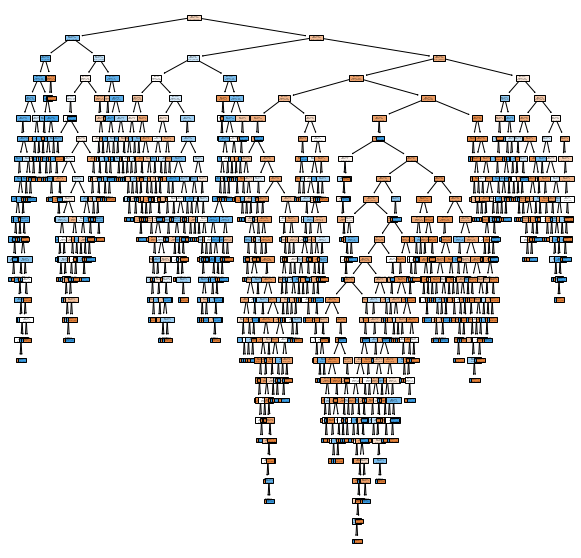

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(decisionTree, 
                   feature_names= Patients_df.columns[0:-1].values,  
                   #class_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"],
                   filled=True)

Wie Sie sehen, unterscheidet sich der Code für den  Einsatz des SVM vom Decision Tree kaum. Dafür bietet uns der Decision Tree die Möglichkeit, die Entscheidungsfindung graphisch zu veranschaulichen (**Explainability**), auch wenn das ganze recht unübersichtlich ist.

Aber die Genauigkeit ist bei beiden Verfahren nicht gerade gut. Deshalb schauen wir mal ob der Einsatz von Ensemble Learning Verfahren bessere Ergebnisse ergibt.

 ### 3.2 Ensemble Learning Verfahren

Ensemble Learning-Verfahren basieren auf der Idee, daß durch Kombination von mehreren "simplen Machine Learning"-Verfahren sich bessere Ergebnisse erreichen lassen. Eine Erklärung der Algorithmen finden Sie in den Vorlesungsfolien und der dort erwähnten Literatur.

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_clf = RandomForestClassifier()
RandomForest_clf.fit(X_train, y_train)

y_pred_RandomForest = RandomForest_clf.predict(X_test)

In [ ]:
Model_accuracy(y_pred_RandomForest, y_test)

[[668  98]
 [228 330]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       766
           1       0.77      0.59      0.67       558

    accuracy                           0.75      1324
   macro avg       0.76      0.73      0.74      1324
weighted avg       0.76      0.75      0.75      1324

accuracy is  0.7537764350453172


Random Forest bietet uns zusätzlich die Funktionalität, aufzuzeigen, welche Features für das Modell am wichtigsten sind, d.h. welche Features/ Eigenschaften das Modell am stärksten gewichtet für die Klassifkation.

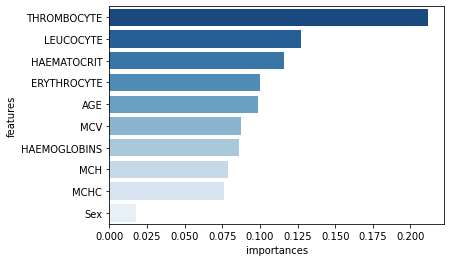

In [ ]:
RandomForest_feature_importances = pd.DataFrame({'features': Patients_df.columns[0:-1].values,
                                        'importances': RandomForest_clf.feature_importances_})

RandomForest_feature_importances.sort_values('importances', ascending = False, inplace = True)

sns.barplot(x = "importances", y = "features", data = RandomForest_feature_importances, palette = "Blues_r")

Wir sehen, daß wir nur durch einfaches Anwenden des Random Forest eine Verbesserung der Genauigkeit von ca. 6% erhalten haben.
Schauen wir uns jetzt noch XGBoost an. 

XGBoost ist in den letzten Jahren quasi der Standardalgorithmus für tabellare Daten im Machine Learning geworden.

#### XGBoost

In [ ]:
import xgboost as xgb

XGB_clf = xgb.XGBClassifier()
XGB_clf.fit(X_train, y_train)

y_pred_XGBT = XGB_clf.predict(X_test)

In [ ]:
Model_accuracy(y_pred_XGBT, y_test)

[[671  95]
 [230 328]]
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       766
           1       0.78      0.59      0.67       558

    accuracy                           0.75      1324
   macro avg       0.76      0.73      0.74      1324
weighted avg       0.76      0.75      0.75      1324

accuracy is  0.7545317220543807


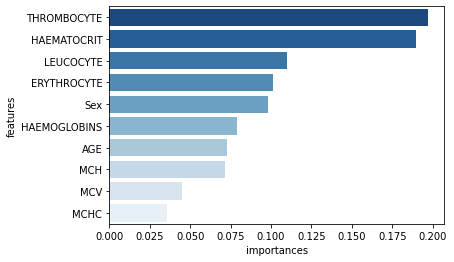

In [ ]:
XGBoost_feature_importances = pd.DataFrame({'features': Patients_df.columns[0:-1].values,
                                        'importances': XGB_clf.feature_importances_})

XGBoost_feature_importances.sort_values('importances', ascending = False, inplace = True)

sns.barplot(x = "importances", y = "features", data = XGBoost_feature_importances, palette = "Blues_r")

Wir sehen, daß beide Ensemble Learning Algorithmen deutlich bessere Ergebnisse erzielten.

Dabei haben wir bis jetzt beide Verfahren direkt eingesetzt, ohne an den Parametern des Modells zu tunen. Dies nennt man sogenanntes **Hyperparameter Tuning** und ermöglicht nochmals deutliche Verbesserungen der Genauigkeit.

## 3.3. Hyperparameter-Tuning

Hyperparameter Tuning ermöglicht nochmals deutliche Verbesserungen, ist aber eine erfahrungsgetriebene Sache und/ oder Ausprobieren.

Hyperparameter sind Werte die das Lernverfahren, nicht jedoch die angegebenen Werte, bspw. hier die Patientendaten, ändern. Einfache Beispiele hierfür sind wie lange man trainiert.

Wir werden uns in diesem Abschnitt folgendes ansehen:
* Detailliertere Erklärung Genauigkeit.
* Auswirkungen Hyperparamter-Tuning auf Genauigkeit von XGBoost oder RandomForest.
* GridSearch-Verfahren für automatisiertes Ausprobieren/ Finden von Hyperparametern.

Detailliertere Informationen zu den möglichen Hyperparametern finden Sie unter [Link](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook) oder [XGBoost Doku](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).

Ein Beispiel für den gesamten Tuningprozess finden Sie unter [Link](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

####3.3.1 Genauigkeit im Machine Learning oder Overfitting vs. Underfitting

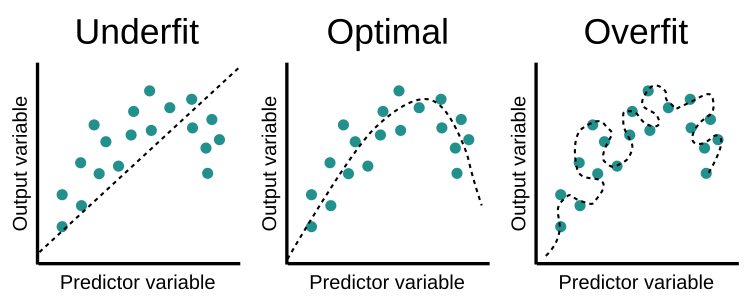

Quelle: [Link](https://www.educative.io/edpresso/overfitting-and-underfitting)

Bevor wir uns im Bild die drei Möglichkeiten, die wir haben können für die Genauigkeit, anschauen zuerst eine genauere Erklärung, was wir unter Genauigkeit verstehen.

Ziel eines Machine Learning-Modells muß es sein, mindestens genauso gut bzw. eher besser als der Mensch zu sein. Das heißt wir nehmen die menschliche Genauigkeit als sogenannte **Ground Truth**. Das Modell muß nun für seine Genauigkeit (Accuracy) besser sein als dieser Wert. 

Das heißt beispielsweise, falls ein Arzt in unserem Fallbeispiel anhand bestimmter Messwerte aus 100 Patienten für genau 70 bestimmen kann ob diese im Krankenhaus bleiben sollten, dann haben wir als Baseline eine Genauigkeit von 
70%.

Wir haben beim Machine Learning zwei Genauigkeiten, die wir dafür nehmen können und zwar die Trainings- und die Testgenauigkeit. Anhand des Vergleichs dieser beiden Genauigkeiten können wir Rückschlüsse auf die Qualität unseres Modells ziehen:
* **Underfitting Modell**: keine hohe Trainings- und Testgenauigkeit und beide sind geringer als die **Ground Truth**. Das Modell ist zu **einfach** und erkennt wesentliche Muster nicht. In dem Fall muß weitergelernt werden.
* **Overfitting Modell**: deutlich höhere Genauigkeit für die Trainings- als für die Testdaten. Das Modell ist sehr gut auf die Trainingsdaten angepaßt und hat diese quasi "auswendig gelernt". Es kann die erkannten Muster aber nicht so gut auf bisher nicht gesehene Daten übertragen - es kann also nicht generalisieren bzw. die wirklich relevanten Dinge lernen. Das Modell ist also zu **komplex**. In dem Fall müssen wir Maßnahmen wie mehr Trainingsdaten, Streichen von Parametern des Modells oder Hyperparameter anpassen.
* **Optimal**: Trainings- und Testgenauigkeit sind relativ gleich und größer oder gleich der Ground Truth. Das Modell ist somit nicht zu einfach und nicht zu komplex und mindestens so gut wie menschliche Experten.

####3.3.2 Auswirkungen Hyperparamter-Tuning auf Genauigkeit von XGBoost

Wir werden uns in diesem Abschnitt genauer ansehen, wie die Wahl welcher Hyperparameter die im vorigen Abschnitt beschriebenen Probleme hervorrufen kann.

Dabei fokussieren wir uns aus Übersichtlichkeitsgründen auf den Paramater *max_depth*. 
Dieser Parameter bestimmt "Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit."(Quelle: [XGBoost Dokumentation](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)).

Wir werden also den Parameter einmal recht gering setzen, um ein zu simples Modell zu erhalten und dann sehr hoch setzen.

Fangen wir mit dem simplen an:

In [ ]:
import xgboost as xgb

XGB_clf_tuning = xgb.XGBClassifier(max_depth=1)
XGB_clf_tuning.fit(X_train, y_train)

y_pred_XGBT_tuning = XGB_clf_tuning.predict(X_test)

In [ ]:
Model_accuracy(y_pred_XGBT_tuning, y_test)

[[687  79]
 [283 275]]
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       766
           1       0.78      0.49      0.60       558

    accuracy                           0.73      1324
   macro avg       0.74      0.69      0.70      1324
weighted avg       0.74      0.73      0.71      1324

accuracy is  0.7265861027190332


Man sieht daß das Einsetzen des Wertes für 1 für max_depth (statt standardmäßig 3) dazu führt, daß die Genauigkeit bei 72% ist. Damit ist sie zwar noch besser als die der simplen Algorithmen, aber deutlich schlechter als die 75% von vorher.

Gehen wir den anderen Schritt und machen das Modell komplexer

In [ ]:
XGB_clf_tuning = xgb.XGBClassifier(max_depth=11) #höherer Wert als 11 macht hier keinen Sinn, da wir nur 11 features haben...
XGB_clf_tuning.fit(X_train, y_train)

y_pred_XGBT_tuning = XGB_clf_tuning.predict(X_test)

In [ ]:
Model_accuracy(y_pred_XGBT_tuning, y_test)

[[655 111]
 [224 334]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       766
           1       0.75      0.60      0.67       558

    accuracy                           0.75      1324
   macro avg       0.75      0.73      0.73      1324
weighted avg       0.75      0.75      0.74      1324

accuracy is  0.7469788519637462


Wir sehen, daß wir mit einer höheren Tiefe zwar deutlich besser sind als mit einer geringeren, aber dafür schlechter als mit dem Standardwert von 3 - auch wenn das nur eine geringer Unterschied ist.

Aber wie wählt man nun die besten Werte? Und das für mehr als einen Hyperparameter? 

Das schauen wir uns im nächsten Abschnitt an.

### 3.3.3 GridSearch

Bei GridSearch definieren wir für ausgewählte Parameter jeweils eine bestimmte Reichweite für jeden der ausgewählten Parameter. Gridsearch probiert dann jede einzelne Kombinatorik der Parameter aus, was recht lange dauern kann.

Anschließend können wir uns die beste Kombination anzeigen lassen und die dann weiter verwenden.

Für das Beispiel hier, wählen wir 3 Paramater aus. Dies macht man auch oft sequentiell für einzelne Parameter und nimmt erst dann neue Parameter hinzu, wenn man mit einem Parameter zufrieden ist. Eine genauere Darstellung finden Sie unter [Link](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).


In [ ]:
param_grid_XGBR = {
    'max_depth' : [1, 3, 6, 11], 
    'eta' : [0.01, 0.3, 0.5, 1], 
    'min_child_weight' : [1, 3, 10]
}

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict

XGB_clf_grid = xgb.XGBClassifier()

GridSearch_XGBoost = GridSearchCV(estimator = XGB_clf_grid,
                                  param_grid = param_grid_XGBR,
                                  scoring='accuracy',
                                  refit = True)

GridSearch_XGBoost.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'eta': [0.01, 0.3, 0.5, 1],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'max_depth': [1, 3, 6, 11],
                         'min_child_weight': [1, 3, 10]},
             scoring='accuracy')

Das Trainieren dauert einige Zeit, da für jede der möglichen Kombinationen das Modell trainiert wird und geschaut wird, wie gut die Ergebnisse sind.

Falls Ihnen das Trainieren und Suchen zu lange dauert, so kommentieren Sie doch einfach für param_grid_XGBR alle Parameter bis auf max_depth aus- in dem Fall sehen Sie dann daß der Suchprozess das gleiche durchführt, wie wir in Abschnitt 3.3.2.

Sobald alles ausprobiert wurde, können wir uns die besten Parameter anzeigen lassen:

In [ ]:
GridSearch_XGBoost.best_params_, GridSearch_XGBoost.best_score_

({'eta': 0.01, 'gamma': 1.5, 'max_depth': 6, 'min_child_weight': 10},
 0.7496713925298841)

Zusätzlich können wir das beste Modell, d.h. den best_estimator nehmen und den auf die vorher nicht gesehenen Daten anwenden und sollten jetzt ein besseres Ergebnis für die Genauigkeit erhalten als zuvor....

In [ ]:
y_pred_XGBT_Grid = GridSearch_XGBoost.best_estimator_.predict(X_test)
Model_accuracy(y_pred_XGBT_Grid, y_test)

[[669  97]
 [224 334]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       766
           1       0.77      0.60      0.68       558

    accuracy                           0.76      1324
   macro avg       0.76      0.74      0.74      1324
weighted avg       0.76      0.76      0.75      1324

accuracy is  0.7575528700906344


Und wir sehen mit 75,7% haben wir bis jetzt das beste Modell erhalten

## Zum Schluß: das Modell im Einsatz

Wir testen jetzt wie das Modell im Einsatz wäre....und zwar an beliebigen Patienten.

Dafür definieren wir einen Patienten mit zufälligen Werten:

In [ ]:
Patient = [[35.1, #HAEMATOCRIT
            11.8, #HAEMOGLOBINS
            4.65, # ERYTHROCYTE
            6.3, # LEUCOCYTE
            310.0, # THROMBOCYTE
            25.4, # MCH
            33.6, # MCHC
            75.5, # MCV
            12.0, # AGE
            1.0]] # Sex

ACHTUNG! XGBoost hat noch einen kleinen Bug, den wir aber wie folgt umgehen können...(Quelle hierfür war Stackoverflow: [Link](https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function))

In [ ]:
Patient_df = pd.DataFrame(Patient, columns = X_test.columns, dtype=float)

In [ ]:
if (GridSearch_XGBoost.best_estimator_.predict(Patient_df) == 0):
  print("Patient wird ambulant behandelt")
else:
  print("Patient bleibt stationär")

# alternativ geht auch folgende Schreibweise:
#print("Patient wird ambulant behandelt") if GridSearch_XGBoost.best_estimator_.predict(Patient) == 0 else print("Patient bleibt stationär")

Patient wird ambulant behandelt
